# `vaex` @ PiterPy Online 2020

##  Анализ миллиарда поездок такси в Нью-Йорке (2009-2015)

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Железо:
* MacBook Pro, 2018 года
* Процессор: 2.6 GHz 6-Core Intel Core i7
* Оперативная память: 32 GB 2400 MHz DDR4
* Жесткий диск: SSD, 500 GB

In [1]:
import vaex
from vaex.ui.colormaps import cm_plusmin

import numpy as np

import pylab as plt
import seaborn as sns

import warnings; warnings.simplefilter('ignore')

### Основные идеи, используемые в `vaex`:
 - Отображение файлов в память (memory mapping)
 - Ленивые вычисления (lazy evaluations)
 - Система выражений ("виртуальные" колонки)
 - Эффективные алгоритмы, параллельное вычисление

### Отображение файлов в память

In [2]:
!du -h /Users/bulatyaminov/fun/datasets/demo/*

107G	/Users/bulatyaminov/fun/datasets/demo/yellow_taxi_2009_2015_f32.hdf5


In [3]:
df = vaex.open('/Users/bulatyaminov/fun/datasets/demo/yellow_taxi_2009_2015_f32.hdf5')

Поддерживается множество форматов данных, в том числе считывание напрямую из S3:
```
df = vaex.open('s3://vaex/taxi/yellow_taxi_2015_f32s.hdf5?anon=true')
```

### Ленивые вычисления

Считываются только те данные, которые нужны для вычисления.

In [4]:
df

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.630000114440918,-73.99195861816406,40.72156524658203,nan,nan,-73.99380493164062,40.6959228515625,8.899999618530273,0.5,nan,0.0,0.0,9.399999618530273
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.550000190734863,-73.98210144042969,40.736289978027344,nan,nan,-73.95584869384766,40.768028259277344,12.100000381469727,0.5,nan,2.0,0.0,14.600000381469727
2,VTS,2009-01-03 15:43:00.000000000,2009-01-03 15:57:00.000000000,5,Credit,10.350000381469727,-74.0025863647461,40.73974609375,nan,nan,-73.86997985839844,40.770225524902344,23.700000762939453,0.0,nan,4.739999771118164,0.0,28.440000534057617
3,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.9742660522461,40.79095458984375,nan,nan,-73.9965591430664,40.731849670410156,14.899999618530273,0.5,nan,3.049999952316284,0.0,18.450000762939453
4,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4000000059604645,-74.00157928466797,40.719383239746094,nan,nan,-74.00837707519531,40.7203483581543,3.700000047683716,0.0,nan,0.0,0.0,3.700000047683716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,173,057,922",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2000000476837158,-73.99381256103516,40.72087097167969,1.0,0.0,-73.98621368408203,40.722469329833984,7.5,0.5,0.5,1.7599999904632568,0.0,10.5600004196167
"1,173,057,923",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527099609375,40.76028060913086,1.0,0.0,-73.93951416015625,40.75238800048828,7.5,0.5,0.5,0.0,0.0,8.800000190734863
"1,173,057,924",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.799999952316284,-73.98729705810547,40.739078521728516,1.0,0.0,-73.9886703491211,40.69329833984375,13.5,0.5,0.5,0.0,0.0,14.800000190734863
"1,173,057,925",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.9600000381469727,-73.99755859375,40.72569274902344,1.0,0.0,-74.01712036132812,40.705322265625,8.5,0.5,0.5,0.0,0.0,9.800000190734863


### Система выражений ("виртуальные" колонки)

Обращение к колонке - одно из выражений.

In [5]:
df.tip_amount

Expression = tip_amount
Length: 1,173,057,927 dtype: float32 (column)
---------------------------------------------
         0     0
         1     2
         2  4.74
         3  3.05
         4     0
      ...       
1173057922  1.76
1173057923     0
1173057924     0
1173057925     0
1173057926  2.96

Создание новой колонки не занимает дополнительную память.

In [6]:
df['tip_percentage'] = df.tip_amount / df.total_amount
df.tip_percentage

Expression = tip_percentage
Length: 1,173,057,927 dtype: float32 (column)
---------------------------------------------
         0         0
         1  0.136986
         2  0.166667
         3  0.165312
         4         0
        ...         
1173057922  0.166667
1173057923         0
1173057924         0
1173057925         0
1173057926  0.166667

То есть можно сразу увидеть примеры данных в новой колонке.

In [7]:
df

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.630000114440918,-73.99195861816406,40.72156524658203,nan,nan,-73.99380493164062,40.6959228515625,8.899999618530273,0.5,nan,0.0,0.0,9.399999618530273,0.0
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.550000190734863,-73.98210144042969,40.736289978027344,nan,nan,-73.95584869384766,40.768028259277344,12.100000381469727,0.5,nan,2.0,0.0,14.600000381469727,0.13698630034923553
2,VTS,2009-01-03 15:43:00.000000000,2009-01-03 15:57:00.000000000,5,Credit,10.350000381469727,-74.0025863647461,40.73974609375,nan,nan,-73.86997985839844,40.770225524902344,23.700000762939453,0.0,nan,4.739999771118164,0.0,28.440000534057617,0.1666666567325592
3,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.9742660522461,40.79095458984375,nan,nan,-73.9965591430664,40.731849670410156,14.899999618530273,0.5,nan,3.049999952316284,0.0,18.450000762939453,0.16531164944171906
4,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4000000059604645,-74.00157928466797,40.719383239746094,nan,nan,-74.00837707519531,40.7203483581543,3.700000047683716,0.0,nan,0.0,0.0,3.700000047683716,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,173,057,922",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2000000476837158,-73.99381256103516,40.72087097167969,1.0,0.0,-73.98621368408203,40.722469329833984,7.5,0.5,0.5,1.7599999904632568,0.0,10.5600004196167,0.1666666567325592
"1,173,057,923",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527099609375,40.76028060913086,1.0,0.0,-73.93951416015625,40.75238800048828,7.5,0.5,0.5,0.0,0.0,8.800000190734863,0.0
"1,173,057,924",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.799999952316284,-73.98729705810547,40.739078521728516,1.0,0.0,-73.9886703491211,40.69329833984375,13.5,0.5,0.5,0.0,0.0,14.800000190734863,0.0
"1,173,057,925",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.9600000381469727,-73.99755859375,40.72569274902344,1.0,0.0,-74.01712036132812,40.705322265625,8.5,0.5,0.5,0.0,0.0,9.800000190734863,0.0


Vaex не будет вычислять выражение, пока не потребуется:
 - Если результат операции - новая колонка, то вычисление будет ленивым.
 - Если результат операции - новая структура данных (число, список), то результат будет вычислен сразу.

In [8]:
df.tip_percentage.mean()

array(inf)

Фильтрация создает виртуальную копию таблицы. Данные не копируются!

In [9]:
df_filtered = df[df.total_amount > 0]

In [10]:
df_filtered.tip_percentage.mean()

array(0.07121788)

### Эффективные алгоритмы

In [11]:
# Check length of file
rows, columns = df.shape
print(f'Number of rows: {rows:,}')
print(f'Number of columns: {columns}')

Number of rows: 1,173,057,927
Number of columns: 19


In [12]:
df['pickup_datetime', 'passenger_count', 'total_amount'].describe()

,pickup_datetime,passenger_count,total_amount
dtype,datetime64[ns],int64,float32
count,1173057927,1173057927,1173057925
NA,0,0,2
mean,1970-01-01T00:00:01.953533625,1.6844313554517245,13.31476581420128
std,6.22239e+16,1.33032,1098.43
min,2009-01-01T00:00:27.365015552,0,-2.14748e+07
max,2016-01-01T00:00:49.632313344,255,3.95061e+06


Когда возможно, используется подход "map/reduce". Например, для вычисления `min`:
* Данные разделяются на куски.
* Процессоры находят `min` для каждого куска.
* Берется `min` среди всех кусков.

Минимизируется кол-во проходов по данным.
* Для внутренних алгоритмов.
* Пользователь [тоже имеет контроль](https://docs.vaex.io/en/latest/tutorial.html#Parallel-computations) при помощи `delay=True` и `df.execute()`:
```
delayed_min = df.min(df.passenger_count, delay=True)
delayed_max = df.max(df.passenger_count, delay=True)
df.execute()  # single pass through the column
print(delayed_min.get(), delayed_max.get())
```

## Пример: анализ данных поездок Нью-Йоркского такси

### Удаление незаполненных строк

In [13]:
# Drop NANs
df = df.dropna(column_names=['dropoff_latitude', 'dropoff_longitude', 'pickup_latitude'])

### Выбор адекватного количества пассажиров

In [14]:
df.passenger_count.value_counts(progress='widget')[:15]

1      812315955
2      172863547
5       81923905
3       51435661
6       25614703
4       24983364
0        3903564
208         1515
7            435
9            352
8            313
49            26
10            17
255           10
129            7
dtype: int64

In [15]:
# Filter abnormal number of passengers
df = df[(df.passenger_count > 0) & (df.passenger_count < 7)]

### Проверка длины поездки

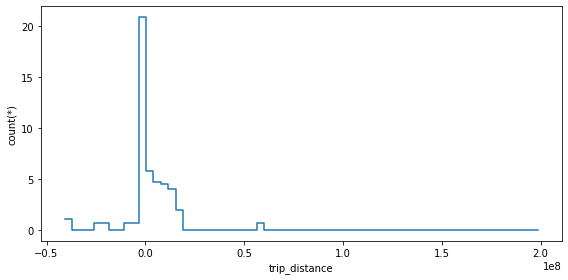

In [16]:
plt.figure(figsize=(8,4))
df.plot1d('trip_distance', limits='minmax', f='log1p', progress='widget')
plt.show()

In [17]:
# How many trips have 0.0 distance?
(df.trip_distance == 0).astype('int').sum()

array(7844544)

In [18]:
# What is the largest distance?
trip_distance_max = df.trip_distance.max(progress='widget')
print()
print(f'Максимальная дистанция среди данных: {trip_distance_max} мили')
print()
print('Это %1.1f от расстояния до Марса!' % (trip_distance_max / 33_900_000))


Максимальная дистанция среди данных: 198623008.0 мили

Это 5.9 от расстояния до Марса!


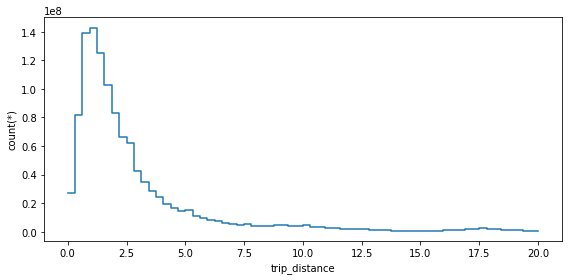

In [19]:
plt.figure(figsize=(8,4))
df.plot1d('trip_distance', limits=[0, 20], f=None, progress='widget')
plt.show()

In [20]:
# Filter negative and too large distances
df = df[(df.trip_distance > 0) & (df.trip_distance < 10)]

### Где чаще всего начинаются поездки?

In [21]:
# Interactively plot the pickup locations
df.plot_widget(df.pickup_longitude, 
               df.pickup_latitude, 
               shape=512, 
               f='log1p', 
               colormap='plasma', 
               limits='minmax')

Heatmap(children=[ToolsToolbar(interact_value=None, supports_normalize=False, template='<template>\n  <v-toolb…

In [22]:
# Define the NYC boundaries
long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

# Make a selection based on the boundaries
df = df[(df.pickup_longitude > long_min)  & (df.pickup_longitude < long_max) & \
        (df.pickup_latitude > lat_min)    & (df.pickup_latitude < lat_max) & \
        (df.dropoff_longitude > long_min) & (df.dropoff_longitude < long_max) & \
        (df.dropoff_latitude > lat_min)   & (df.dropoff_latitude < lat_max)]

### Обработка дат

In [23]:
# Daily activities
df['pickup_hour'] = df.pickup_datetime.dt.hour
df['pickup_day_of_week'] = df.pickup_datetime.dt.dayofweek
df['pickup_is_weekend'] = (df.pickup_day_of_week >= 5).astype('int')

# Treat as a categorical feature
df.categorize(column='pickup_hour', inplace=True)

weekday_names_list = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df.categorize(column='pickup_day_of_week', labels=weekday_names_list, inplace=True)
df

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage,pickup_hour,pickup_day_of_week,pickup_is_weekend
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.630000114440918,-73.99195861816406,40.72156524658203,nan,nan,-73.99380493164062,40.6959228515625,8.899999618530273,0.5,nan,0.0,0.0,9.399999618530273,0.0,2,6,1
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.550000190734863,-73.98210144042969,40.736289978027344,nan,nan,-73.95584869384766,40.768028259277344,12.100000381469727,0.5,nan,2.0,0.0,14.600000381469727,0.13698630034923553,3,6,1
2,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.9742660522461,40.79095458984375,nan,nan,-73.9965591430664,40.731849670410156,14.899999618530273,0.5,nan,3.049999952316284,0.0,18.450000762939453,0.16531164944171906,20,3,0
3,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4000000059604645,-74.00157928466797,40.719383239746094,nan,nan,-74.00837707519531,40.7203483581543,3.700000047683716,0.0,nan,0.0,0.0,3.700000047683716,0.0,16,5,1
4,DDS,2009-01-16 22:35:59.000000000,2009-01-16 22:43:35.000000000,2,CASH,1.2000000476837158,-73.98980712890625,40.73500442504883,nan,nan,-73.98502349853516,40.72449493408203,6.099999904632568,0.5,nan,0.0,0.0,6.599999904632568,0.0,22,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,083,167,545",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2000000476837158,-73.99381256103516,40.72087097167969,1.0,0.0,-73.98621368408203,40.722469329833984,7.5,0.5,0.5,1.7599999904632568,0.0,10.5600004196167,0.1666666567325592,23,3,0
"1,083,167,546",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527099609375,40.76028060913086,1.0,0.0,-73.93951416015625,40.75238800048828,7.5,0.5,0.5,0.0,0.0,8.800000190734863,0.0,23,3,0
"1,083,167,547",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.799999952316284,-73.98729705810547,40.739078521728516,1.0,0.0,-73.9886703491211,40.69329833984375,13.5,0.5,0.5,0.0,0.0,14.800000190734863,0.0,23,3,0
"1,083,167,548",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.9600000381469727,-73.99755859375,40.72569274902344,1.0,0.0,-74.01712036132812,40.705322265625,8.5,0.5,0.5,0.0,0.0,9.800000190734863,0.0,23,3,0


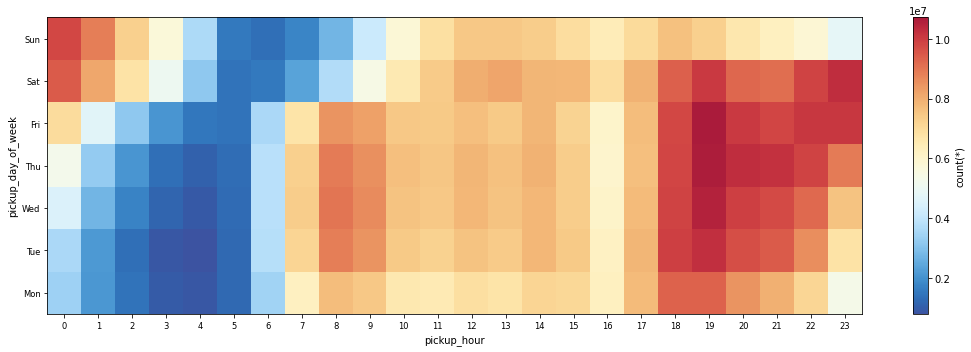

In [24]:
# Number of pick-ups per hour for a given day of the week
df.plot('pickup_hour', 'pickup_day_of_week', colorbar=True, colormap=cm_plusmin, figsize=(15, 5))

plt.xticks(np.arange(24), np.arange(24))
plt.yticks(np.arange(7), weekday_names_list)
plt.show()

### Группирование

In [25]:
df_per_hour = df.groupby(by=df.pickup_hour).agg({'tip_amount': 'mean'})
df_per_hour

#,pickup_hour,tip_amount
0,0,1.0583148055719316
1,1,1.0395988285791358
2,2,1.0271794254275992
3,3,1.0004258190973754
4,4,0.9259400499895432
...,...,...
19,19,1.0345855021860877
20,20,1.0202804182400866
21,21,1.0258125215768232
22,22,1.0711251054555473


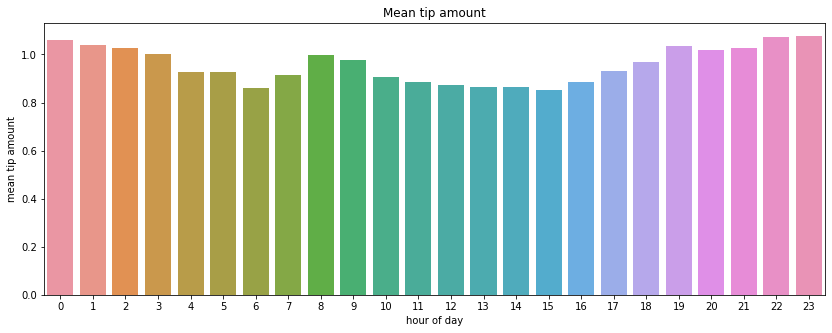

In [26]:
plt.figure(figsize=(14, 5))

sns.barplot(x=df_per_hour.pickup_hour.values, y=df_per_hour.tip_amount.values)
plt.title('Mean tip amount')
plt.xlabel('hour of day')
plt.ylabel('mean tip amount')

plt.show()

### Больше примеров можно найти [в документации](https://docs.vaex.io/en/latest/tutorial.html).